<a href="https://colab.research.google.com/github/Intertangler/ML4biotech/blob/main/neural_network_training_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## exercise - training neural networks
In this exercise we have an artificial dataset of gene expression values for multiple individuals and 16 different genes. The data were generated such as to have a class label or "outcome" variable that we might say cooresponds to a physiological outcome (e.g. pathological status or not). The goal of this exercise is to get a little practical experience diagnosing some common issues with training neural networks when trying to get good performance. Start by running the two cells below to import the expression data and visualize with histograms.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

#import csv gene expression data
github_url = 'https://raw.githubusercontent.com/Intertangler/ML4biotech/main/gene_data_complex.csv'
df = pd.read_csv(github_url)
n_individuals = len(df)
n_genes = 16
outcome = df['outcome'].values
gene_data = {}
for gene_idx in range(n_genes):
    gene_data[gene_idx] = {
        'expression': df[f'gene_{gene_idx}_expression'].values,
        'on_state': df[f'gene_{gene_idx}_on_state'].values.astype(bool)
    }
# plot histograms of the expression for each gene
x_range = np.linspace(0, 200, 50)
fig, axes = plt.subplots(n_genes, 2, figsize=(10, 25))
for idx in range(n_genes):
    expression = gene_data[idx]['expression']
    axes[idx, 0].hist(expression, bins=x_range, color='blue', edgecolor='black', density=True)
    axes[idx, 0].set_ylim([0, .5])
    axes[idx, 1].hist(expression, bins=x_range, color='green', edgecolor='black', log=True, density=True)
    axes[idx, 1].set_ylim([0.001, 1])
plt.tight_layout()
plt.show()


## scaling gene expression data

In order to have the input data on the correct scale, we will squash it into a range from 0 to 1. This process is called normalization.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

all_gene_expressions = np.zeros((n_individuals, n_genes))
for gene_idx in range(n_genes):
    all_gene_expressions[:, gene_idx] = gene_data[gene_idx]['expression']

log_gene_expressions = np.log1p(all_gene_expressions)
scaler = MinMaxScaler()
scaled_gene_expressions = scaler.fit_transform(log_gene_expressions)

# plotting the rescaled data
max_scaled_expression = np.max(scaled_gene_expressions)
x_scaled_range = np.linspace(0, max_scaled_expression, 50)
fig, axes = plt.subplots(n_genes, 2, figsize=(10, 25))
for idx in range(n_genes):
    scaled_expression = scaled_gene_expressions[:, idx]
    axes[idx, 0].hist(scaled_expression, bins=x_scaled_range, color='blue', edgecolor='black', density=True)
    axes[idx, 1].hist(scaled_expression, bins=x_scaled_range, color='green', edgecolor='black', log=True, density=True)

plt.tight_layout()
plt.show()


### underperforming neural network 1
Examine the code below and try to diagnose the problem with this currently under-performing network. Utilize your understanding of the data that is being analyzed, the techniques commonly employed during training, and experimentation to figure out what is going on.

Epoch 1 - loss: 1.1731232404708862
Epoch 11 - loss: 1.1018410921096802
Epoch 21 - loss: 1.0595916509628296
Epoch 31 - loss: 1.0203522443771362
Epoch 41 - loss: 0.9832767248153687
Epoch 51 - loss: 0.9488471746444702
Epoch 61 - loss: 0.9170596599578857
Epoch 71 - loss: 0.8881152868270874
Epoch 81 - loss: 0.8622826933860779
Epoch 91 - loss: 0.8390025496482849
32/32 [==============================] - 0s 1ms/step


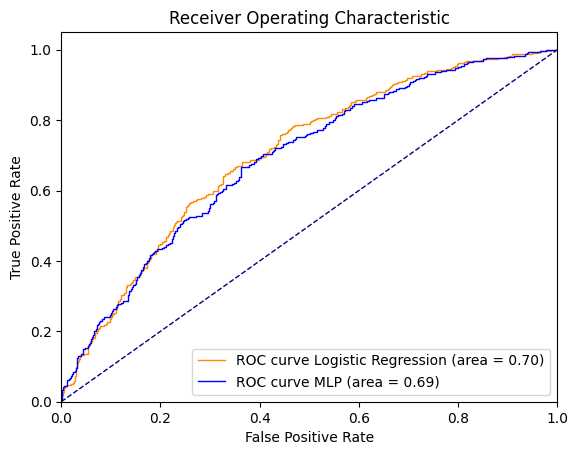

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers


X_train, X_test, y_train, y_test = train_test_split(scaled_gene_expressions, outcome, test_size=0.5, random_state=1234)


# training the logistic regression for comparison
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
# ROC evaluation stuff for the logistic regression only:
y_score = logistic_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


# neural network architecture part
model = Sequential([
    Dense(32, input_dim=n_genes, activation='relu', kernel_regularizer=regularizers.l1(0.005)),
    Dense(1, activation='sigmoid')
])

# Compile the model using the ADAM adaptive moment estimation optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# callback to print loss every 10 epochs
print_loss_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch + 1} - loss: {logs['loss']}") if epoch % 10 == 0 else None
)

# Train the model
history = model.fit(X_train, y_train, epochs=100, verbose=0, callbacks=print_loss_callback, validation_split=0.2)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
difference = [abs(t - v) for t, v in zip(train_loss, val_loss)]

# ROC curve
y_score_mlp = model.predict(X_test).ravel()

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_score_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve Logistic Regression (area = {roc_auc:.2f})')
plt.plot(fpr_mlp, tpr_mlp, color='blue', lw=1, label=f'ROC curve MLP (area = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")




### diagnose network 2
Same data, different setup. What is wrong with this one?

Epoch 1 - loss: 0.6927654147148132
Epoch 11 - loss: 0.6681730151176453
Epoch 21 - loss: 0.6121349930763245
Epoch 31 - loss: 0.5714922547340393
Epoch 41 - loss: 0.529740571975708
Epoch 51 - loss: 0.4939042925834656
Epoch 61 - loss: 0.4294692575931549
Epoch 71 - loss: 0.3984144926071167
Epoch 81 - loss: 0.35298019647598267
Epoch 91 - loss: 0.34040310978889465
Epoch 101 - loss: 0.321216344833374
Epoch 111 - loss: 0.288676381111145
Epoch 121 - loss: 0.24033020436763763
Epoch 131 - loss: 0.24824035167694092
Epoch 141 - loss: 0.20471225678920746
Epoch 151 - loss: 0.1975628137588501
Epoch 161 - loss: 0.1962612122297287
Epoch 171 - loss: 0.176492840051651
Epoch 181 - loss: 0.1680060774087906
Epoch 191 - loss: 0.17197543382644653
Epoch 201 - loss: 0.16688239574432373
Epoch 211 - loss: 0.14400331676006317
Epoch 221 - loss: 0.137992724776268
Epoch 231 - loss: 0.13216176629066467
Epoch 241 - loss: 0.20588454604148865
Epoch 251 - loss: 0.12978123128414154
Epoch 261 - loss: 0.12713459134101868
Epoch

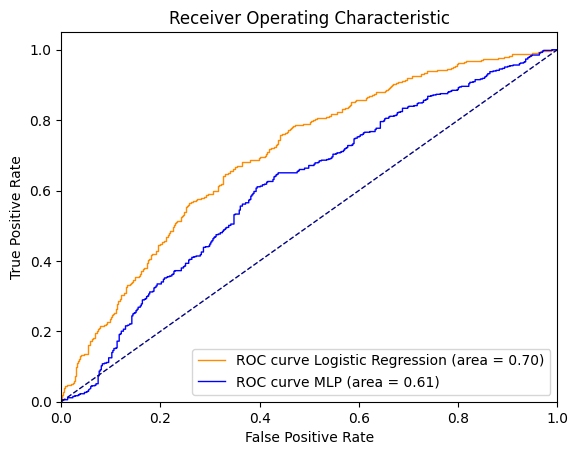

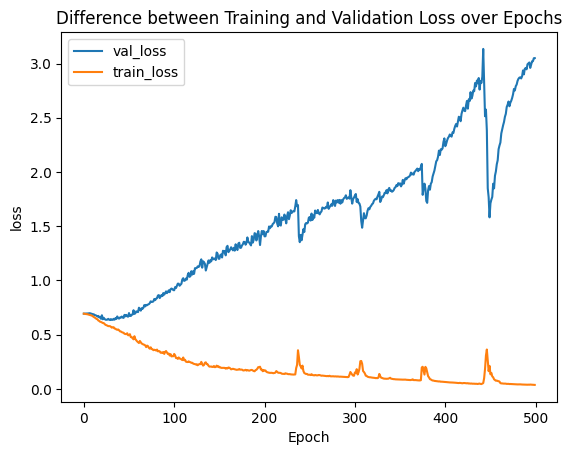

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


X_train, X_test, y_train, y_test = train_test_split(scaled_gene_expressions, outcome, test_size=0.5, random_state=1234)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_score = logistic_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


# model architecture
model = Sequential([
    Dense(10, input_dim=n_genes, activation='relu'),
    Dense(10, input_dim=n_genes, activation='relu'),
    Dense(10, input_dim=n_genes, activation='relu'),
    Dense(10, input_dim=n_genes, activation='relu'),
    Dense(10, input_dim=n_genes, activation='relu'),
    Dense(10, input_dim=n_genes, activation='relu'),
    Dense(10, input_dim=n_genes, activation='relu'),
    Dense(10, input_dim=n_genes, activation='relu'),
    Dense(1, activation='sigmoid')
])
# Compile
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# callback
print_loss_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch + 1} - loss: {logs['loss']}") if epoch % 10 == 0 else None
)

# Train
history=model.fit(X_train, y_train, epochs=500, verbose=0, callbacks=print_loss_callback, validation_split=0.6)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
difference = [abs(t - v) for t, v in zip(train_loss, val_loss)]

# ROC curve
y_score_mlp = model.predict(X_test).ravel()

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_score_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve Logistic Regression (area = {roc_auc:.2f})')
plt.plot(fpr_mlp, tpr_mlp, color='blue', lw=1, label=f'ROC curve MLP (area = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()
plt.figure()
plt.plot(val_loss, label='val_loss')
plt.plot(train_loss, label='train_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Difference between Training and Validation Loss over Epochs')
plt.legend()
plt.show()


### underperforming network 3
In this network, early stopping, dropout layers, and minibatch sampling have been added. Can you figure out what is wrong with the model?

Epoch 1 - loss: 1.139431357383728
Epoch 11 - loss: 0.598503589630127
Epoch 21 - loss: 0.5696045160293579
Epoch 31 - loss: 0.5556807518005371
32/32 [==============================] - 0s 2ms/step


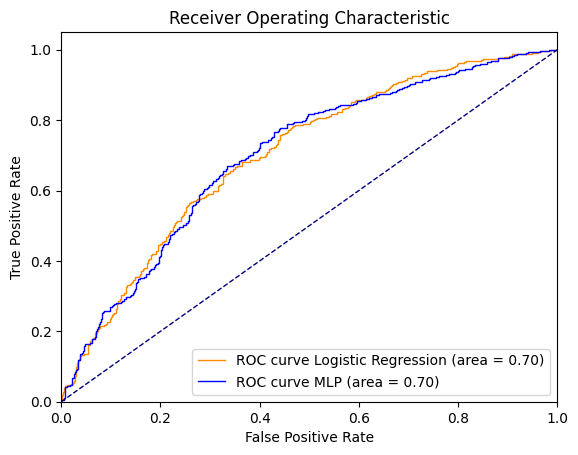

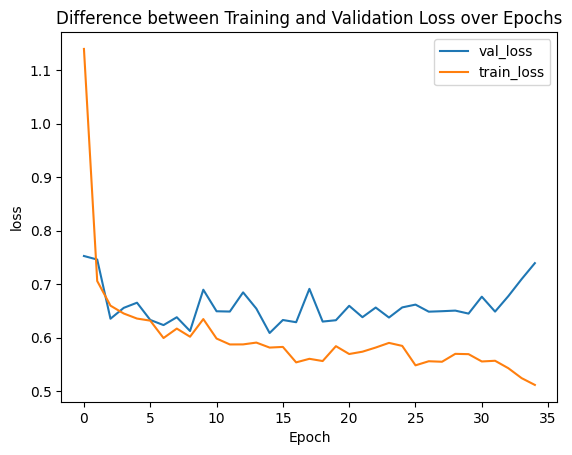

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


# Split the preprocessed data
X_train, X_test, y_train, y_test = train_test_split(scaled_gene_expressions, outcome, test_size=0.5, random_state=1234)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

model = Sequential([
    Dense(800, input_dim=n_genes, activation='relu'),
    Dropout(.5),
    Dense(1, activation='sigmoid')
])
# Compile the model
optimizer = Adam(learning_rate=0.05)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# Custom callback to print loss every 100 epochs
print_loss_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch + 1} - loss: {logs['loss']}") if epoch % 10 == 0 else None
)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=0, callbacks=[print_loss_callback, early_stopping], validation_split=0.6)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
difference = [abs(t - v) for t, v in zip(train_loss, val_loss)]

# Evaluate the model and plot ROC curve
y_score_mlp = model.predict(X_test).ravel()

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_score_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve Logistic Regression (area = {roc_auc:.2f})')
plt.plot(fpr_mlp, tpr_mlp, color='blue', lw=1, label=f'ROC curve MLP (area = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

plt.show()
plt.figure()
plt.plot(val_loss, label='val_loss')
plt.plot(train_loss, label='train_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Difference between Training and Validation Loss over Epochs')
plt.legend()
plt.show()

